# Dataset 4 - Boston

## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../src')
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import bostonDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from torch.utils.data import random_split 
#import pycuda.driver as cuda

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 13
n_samples= 506
 
#ABC Generator Parameters
mean = 1 
variance = 0.01

#Hyper-parameters 
n_epochs = 5000

In [4]:
# Parameters
mean = 1
variance = 0.1
n_epochs = 5000


## Dataset

In [5]:
X,Y = bostonDataset.boston_data()

        X1    X2    X3   X4     X5     X6    X7      X8   X9    X10   X11  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

      X12   X13     Y  
0  396.90  4.98  24.0  
1  396.90  9.14  21.6  
2  392.83  4.03  34.7  
3  394.63  2.94  33.4  
4  396.90  5.33  36.2  


## Stats Model

No handles with labels found to put in legend.


                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.731
Model:                            OLS   Adj. R-squared (uncentered):              0.722
Method:                 Least Squares   F-statistic:                              81.79
Date:                Wed, 17 Nov 2021   Prob (F-statistic):                   8.22e-103
Time:                        19:32:25   Log-Likelihood:                         -313.30
No. Observations:                 404   AIC:                                      652.6
Df Residuals:                     391   BIC:                                      704.6
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

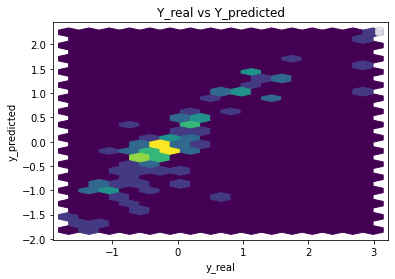

Performance Metrics
Mean Squared Error: 0.19960429102357022
Mean Absolute Error: 0.3004052066644836
Manhattan distance: 30.641331079777334
Euclidean distance: 4.512165520501675


In [6]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [7]:
threshold_mse = 0.99
batch_size = 100

In [8]:
# Train test split for dataset 
real_dataset = dataset.CustomDataset(X,Y)
train_size = round(0.8 * n_samples)
test_size = n_samples - train_size
train_data, test_data = random_split(real_dataset,[train_size,test_size])

In [9]:
# cuda.init()
# ## Get Id of default device
# torch.cuda.current_device()
# #0
# cuda.Device(0).name()

In [10]:
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## GAN Model

**Training GAN for n_epochs number of epochs** 

In [11]:
generator = network.Generator(n_features+1).to(device)
discriminator = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [12]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=14, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=14, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [13]:
discLossG1,genLossG1 = train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,device)

In [14]:
GAN1_metrics = train_test.test_generator(generator,test_data,device)

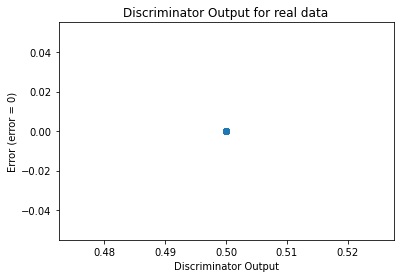

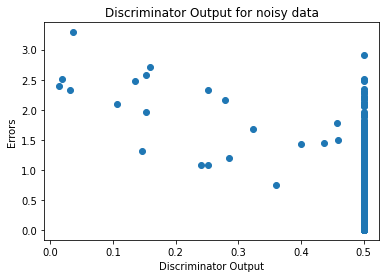

In [15]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until mse of y_pred is > baseline_mse or n_epochs < 5000**

In [16]:
generator2 = network.Generator(n_features+1).to(device)
discriminator2 = network.Discriminator(n_features+1).to(device)
criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [17]:
discLossG2,genLossG2 = train_test.training_GAN_2(discriminator2,generator2,disc_opt,gen_opt,train_data,test_data,batch_size,threshold_mse,criterion,device)

Number of epochs needed 5


In [18]:
GAN2_metrics=train_test.test_generator_2(generator2,test_data,device)

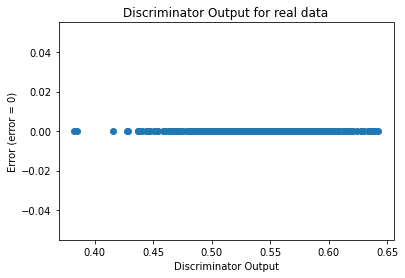

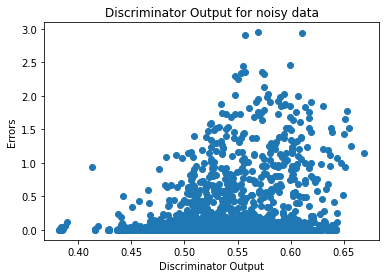

In [19]:
sanityChecks.discProbVsError(real_dataset,discriminator2,device)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [20]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [21]:
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,mean,variance,device)

In [22]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,test_data,coeff,mean,variance,device)

#### Sanity Checks 

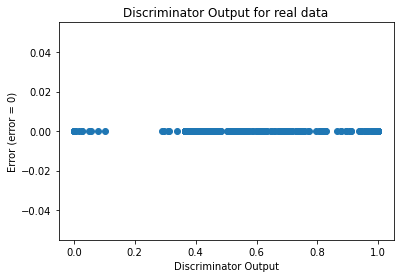

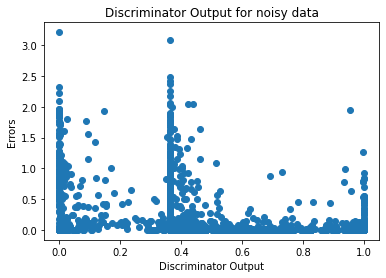

In [23]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training ABC-GAN until mse of y_pred is > baseline_mse or n_epochs < 5000**

In [24]:
gen2 = network.Generator(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [25]:
discLossA2,genLossA2 = ABC_train_test.training_GAN_2(disc2,gen2,disc_opt,gen_opt,train_data,test_data,batch_size,threshold_mse,criterion,coeff,mean,variance,device)

Number of epochs 3


In [26]:
ABC_GAN2_metrics=ABC_train_test.test_generator_2(gen2,test_data,coeff,mean,variance,device)

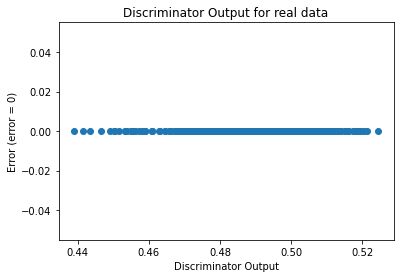

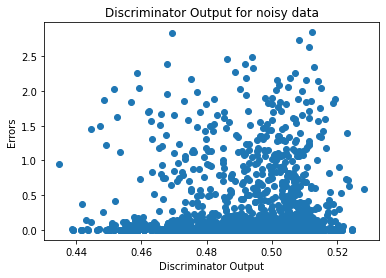

In [27]:
sanityChecks.discProbVsError(real_dataset,disc2,device)

# Model Analysis

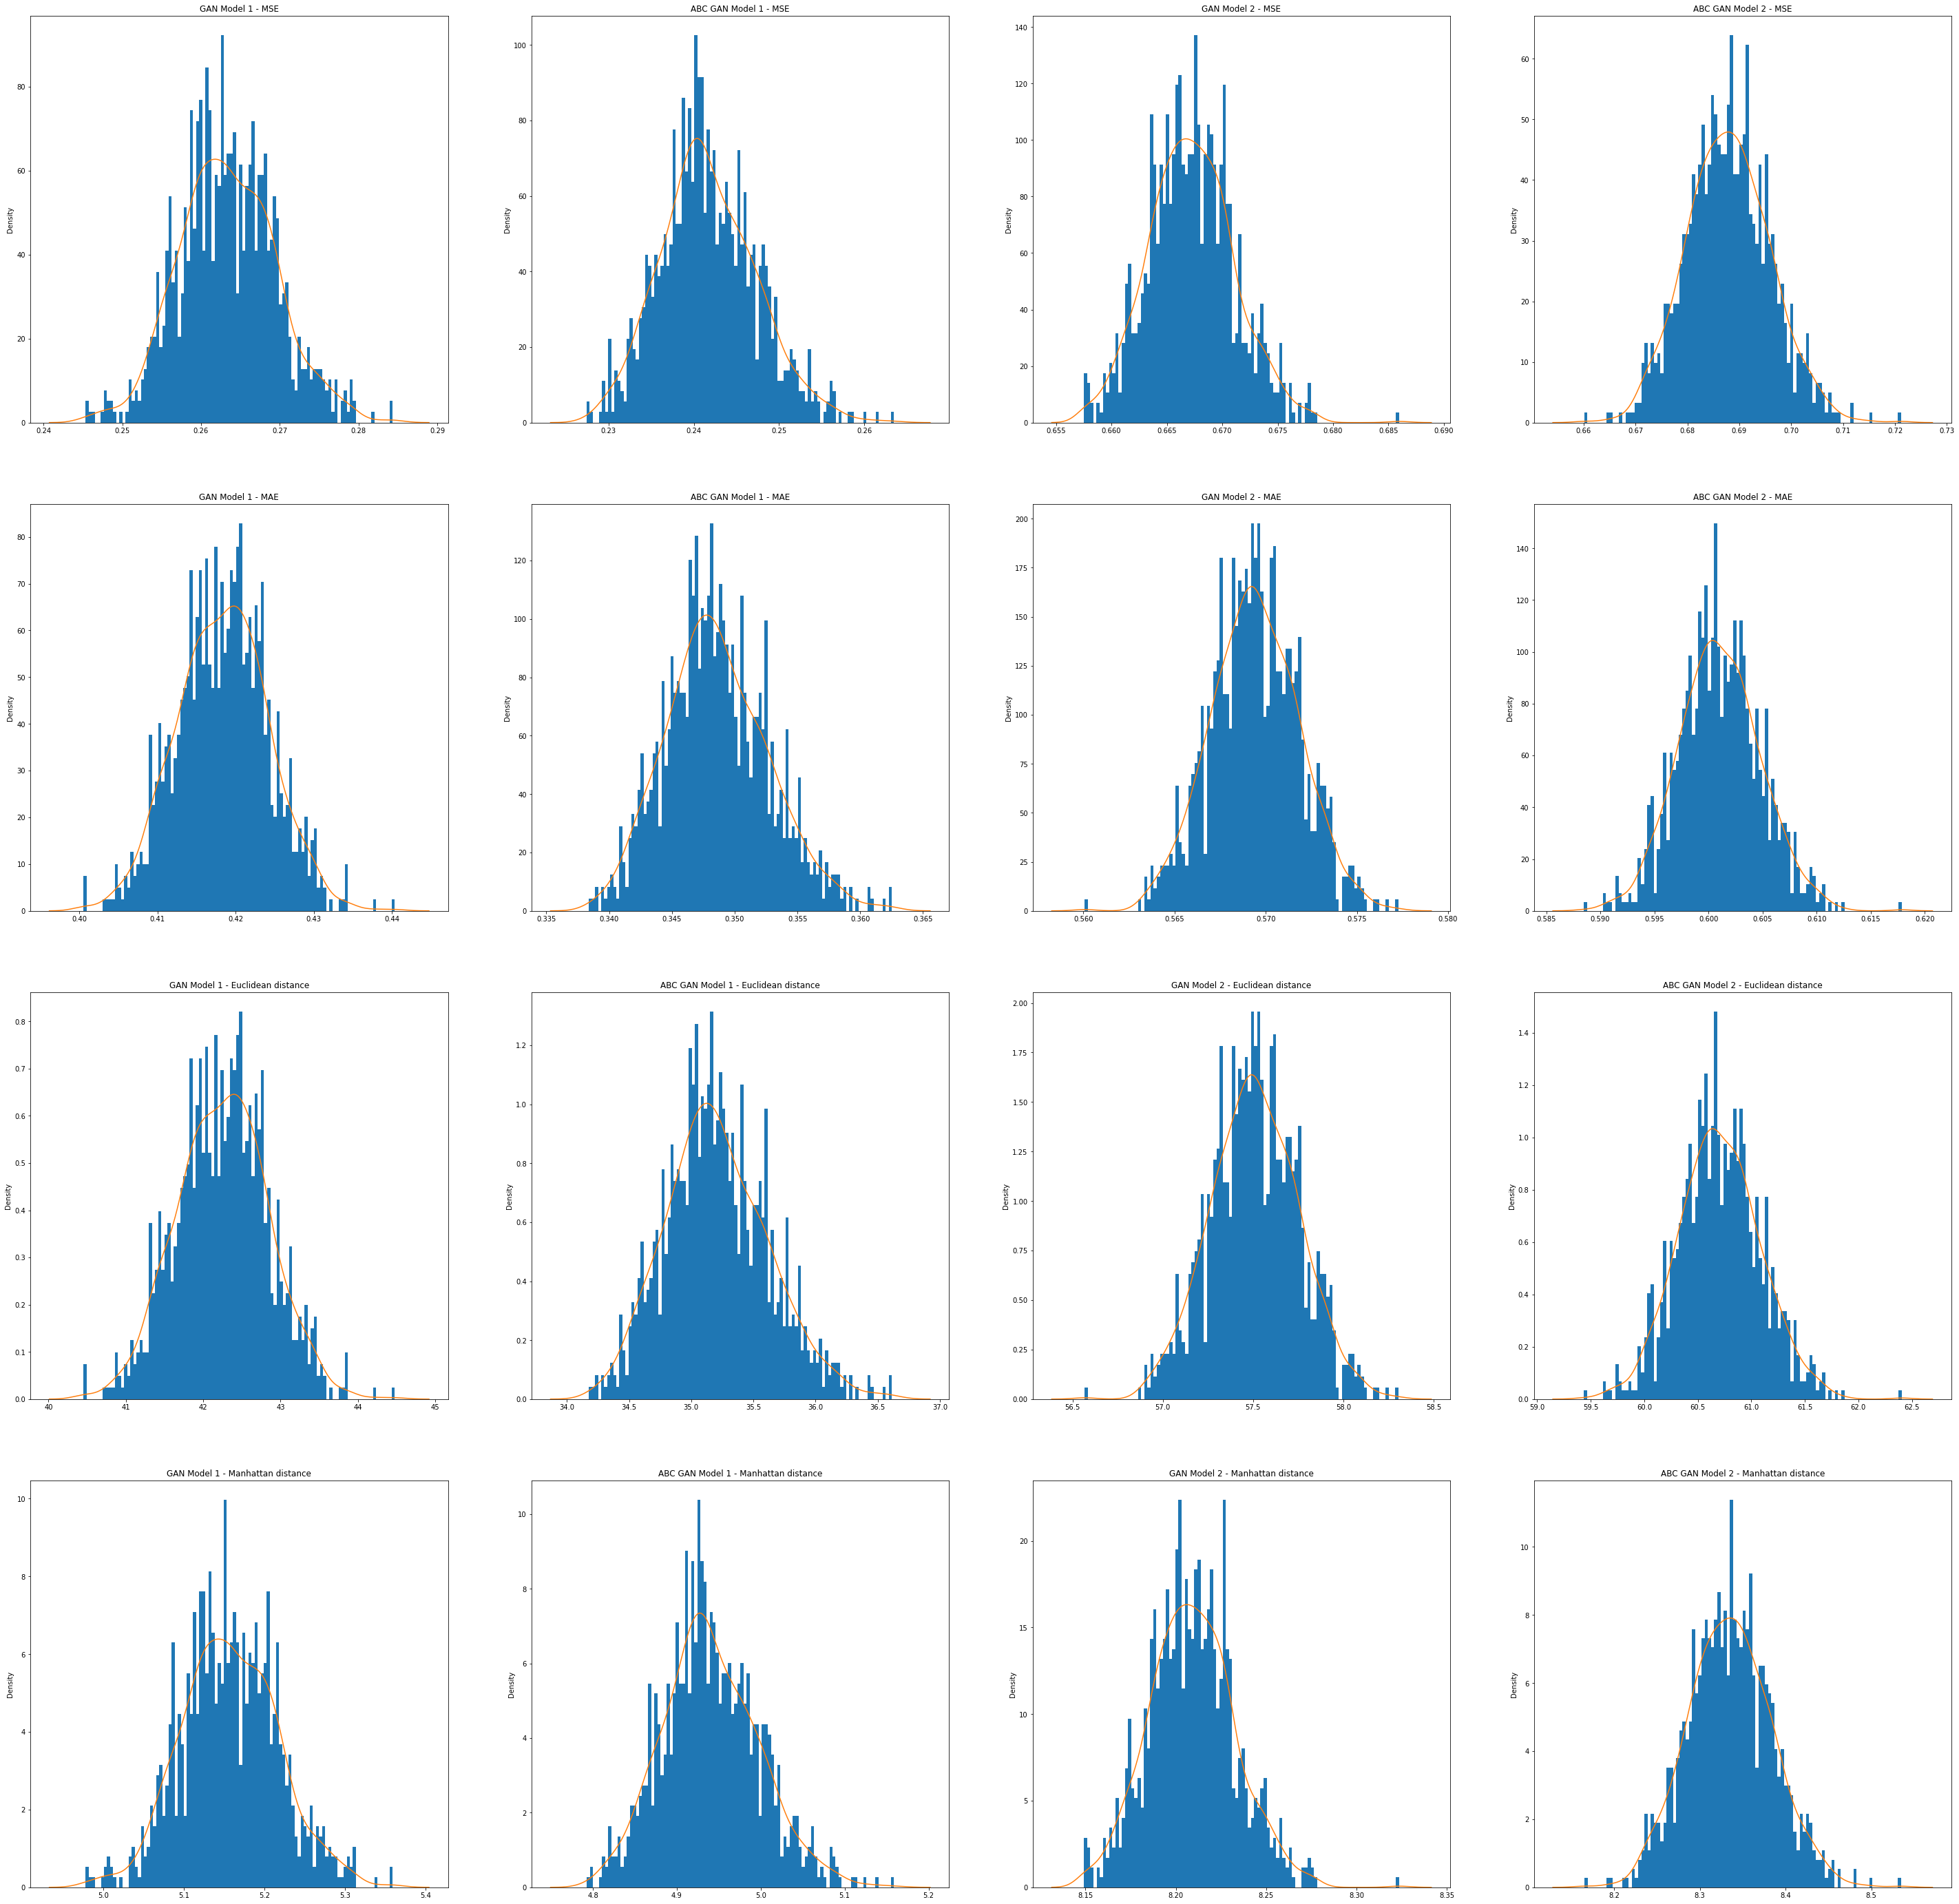

In [28]:
performanceMetrics.modelAnalysis(GAN1_metrics,ABC_GAN1_metrics,GAN2_metrics,ABC_GAN2_metrics)

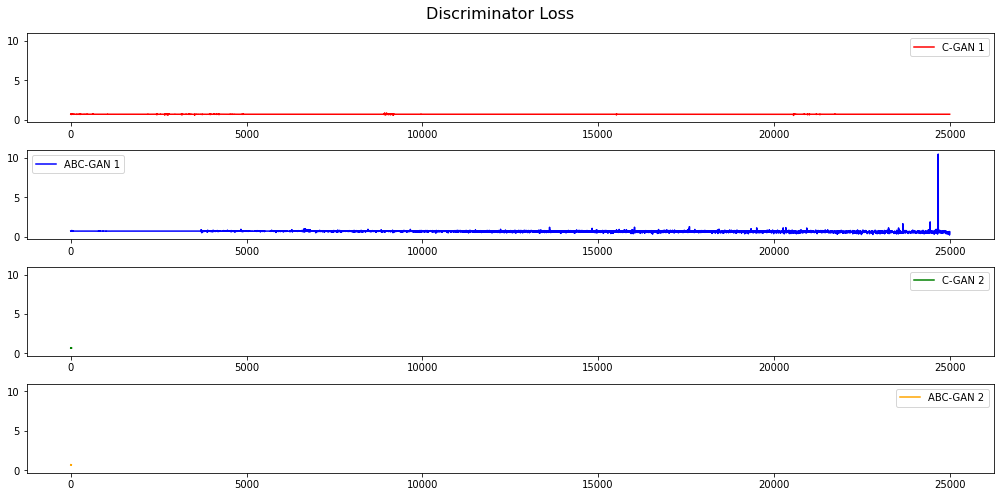

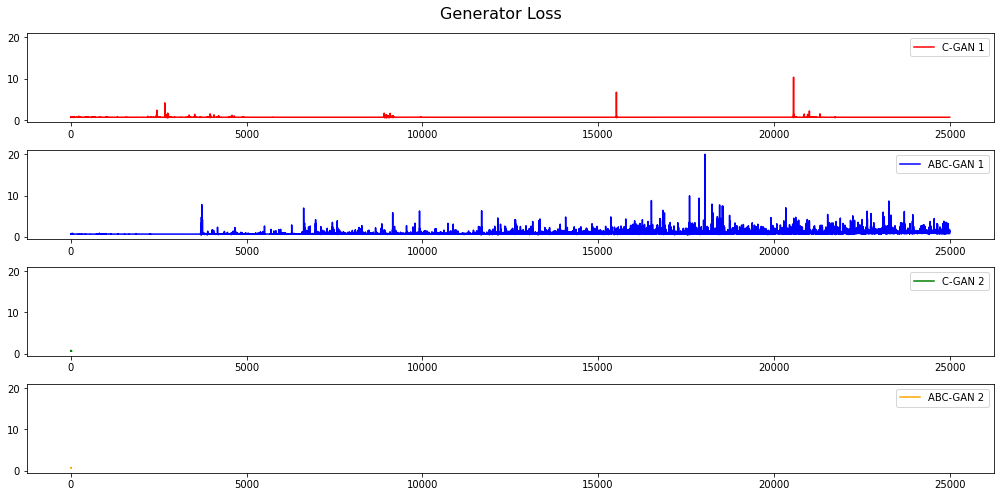

In [29]:
performanceMetrics.plotTrainingLoss(discLossG1,genLossG1,discLossA1,genLossA1,discLossG2,genLossG2,discLossA2,genLossA2)

## GAN Model with skip connection

In [30]:
generator3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
discriminator3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator3.parameters(), lr=0.01, betas=(0.5, 0.999))

In [31]:
discLossG3,genLossG3 = train_test.training_GAN(discriminator3,generator3 ,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,device)

In [32]:
GAN3_metrics=ABC_train_test.test_generator(generator3,test_data,coeff,mean,variance,device)

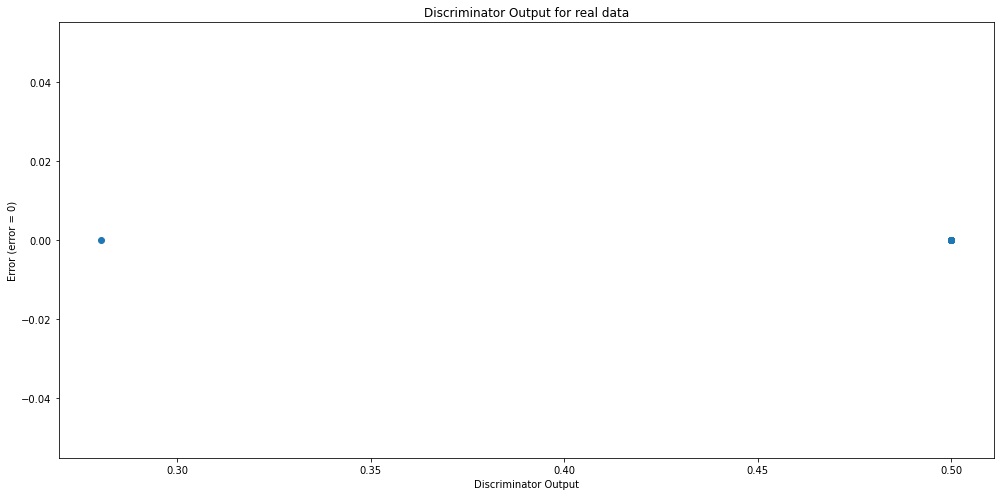

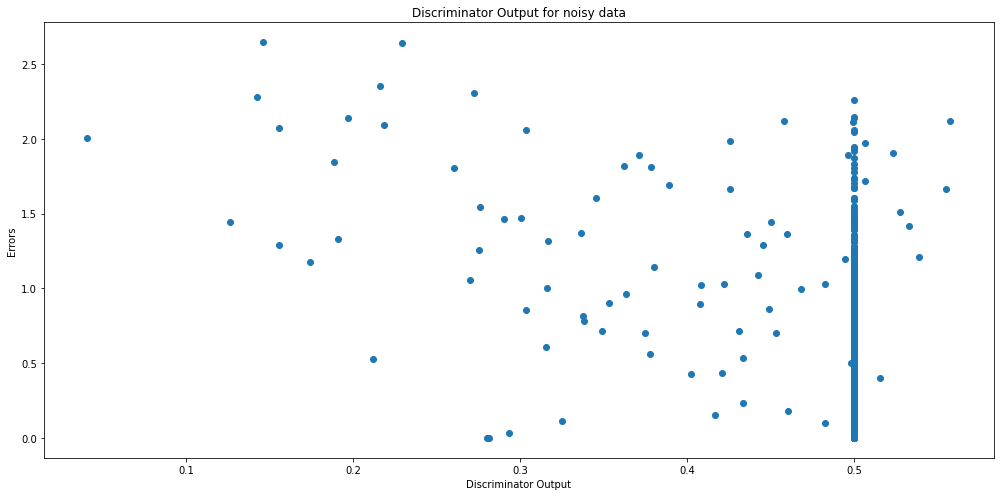

In [33]:
sanityChecks.discProbVsError(real_dataset,discriminator3,device)

## ABC - GAN Model with skip connection

In [34]:
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.01, betas=(0.5, 0.999))

In [35]:
discLossA3,genLossA3 = ABC_train_test.training_GAN(disc3, gen3,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,mean,variance,device)

In [36]:
ABC_GAN3_metrics=ABC_train_test.test_generator(gen3,test_data,coeff,mean,variance,device)

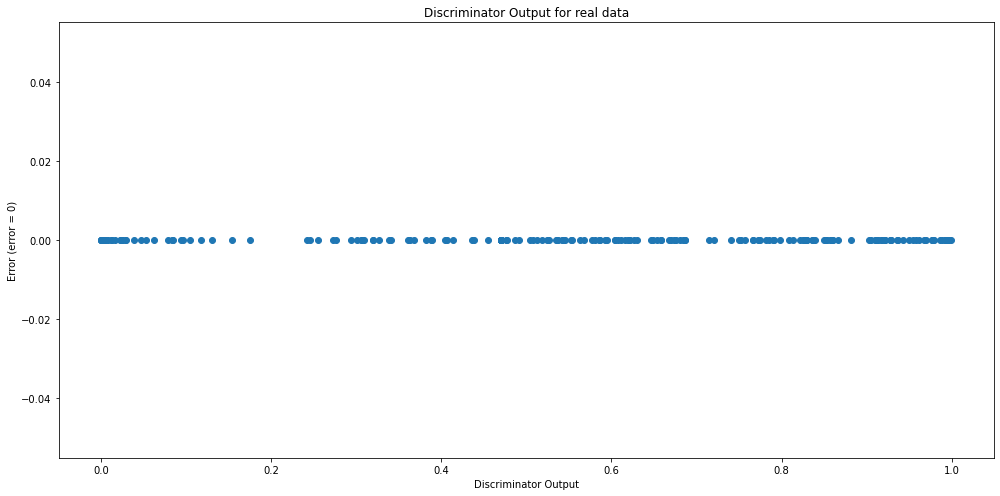

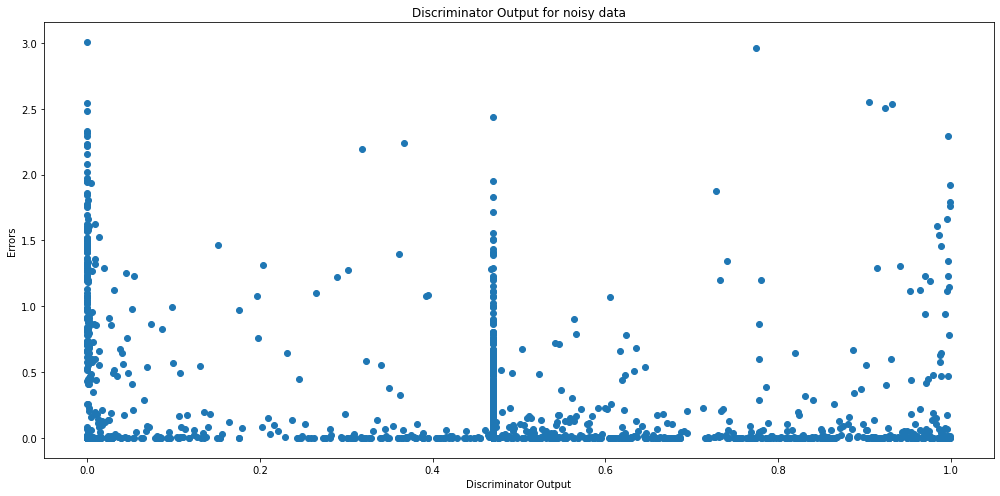

In [37]:
sanityChecks.discProbVsError(real_dataset,disc3,device)

In [38]:
## Skip Connection Model Analysis - GAN and ABC-GAN 

In [39]:
### Weight Analysis 

##Study the weights of the skip connection layer

In [40]:
print("GAN Weights")
for name,param in generator3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
print("ABC-GAN Weights")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)

GAN Weights
Parameter containing:
tensor([[-0.0932, -0.0642]], requires_grad=True)
ABC-GAN Weights
Parameter containing:
tensor([[-0.1019,  0.6159]], requires_grad=True)


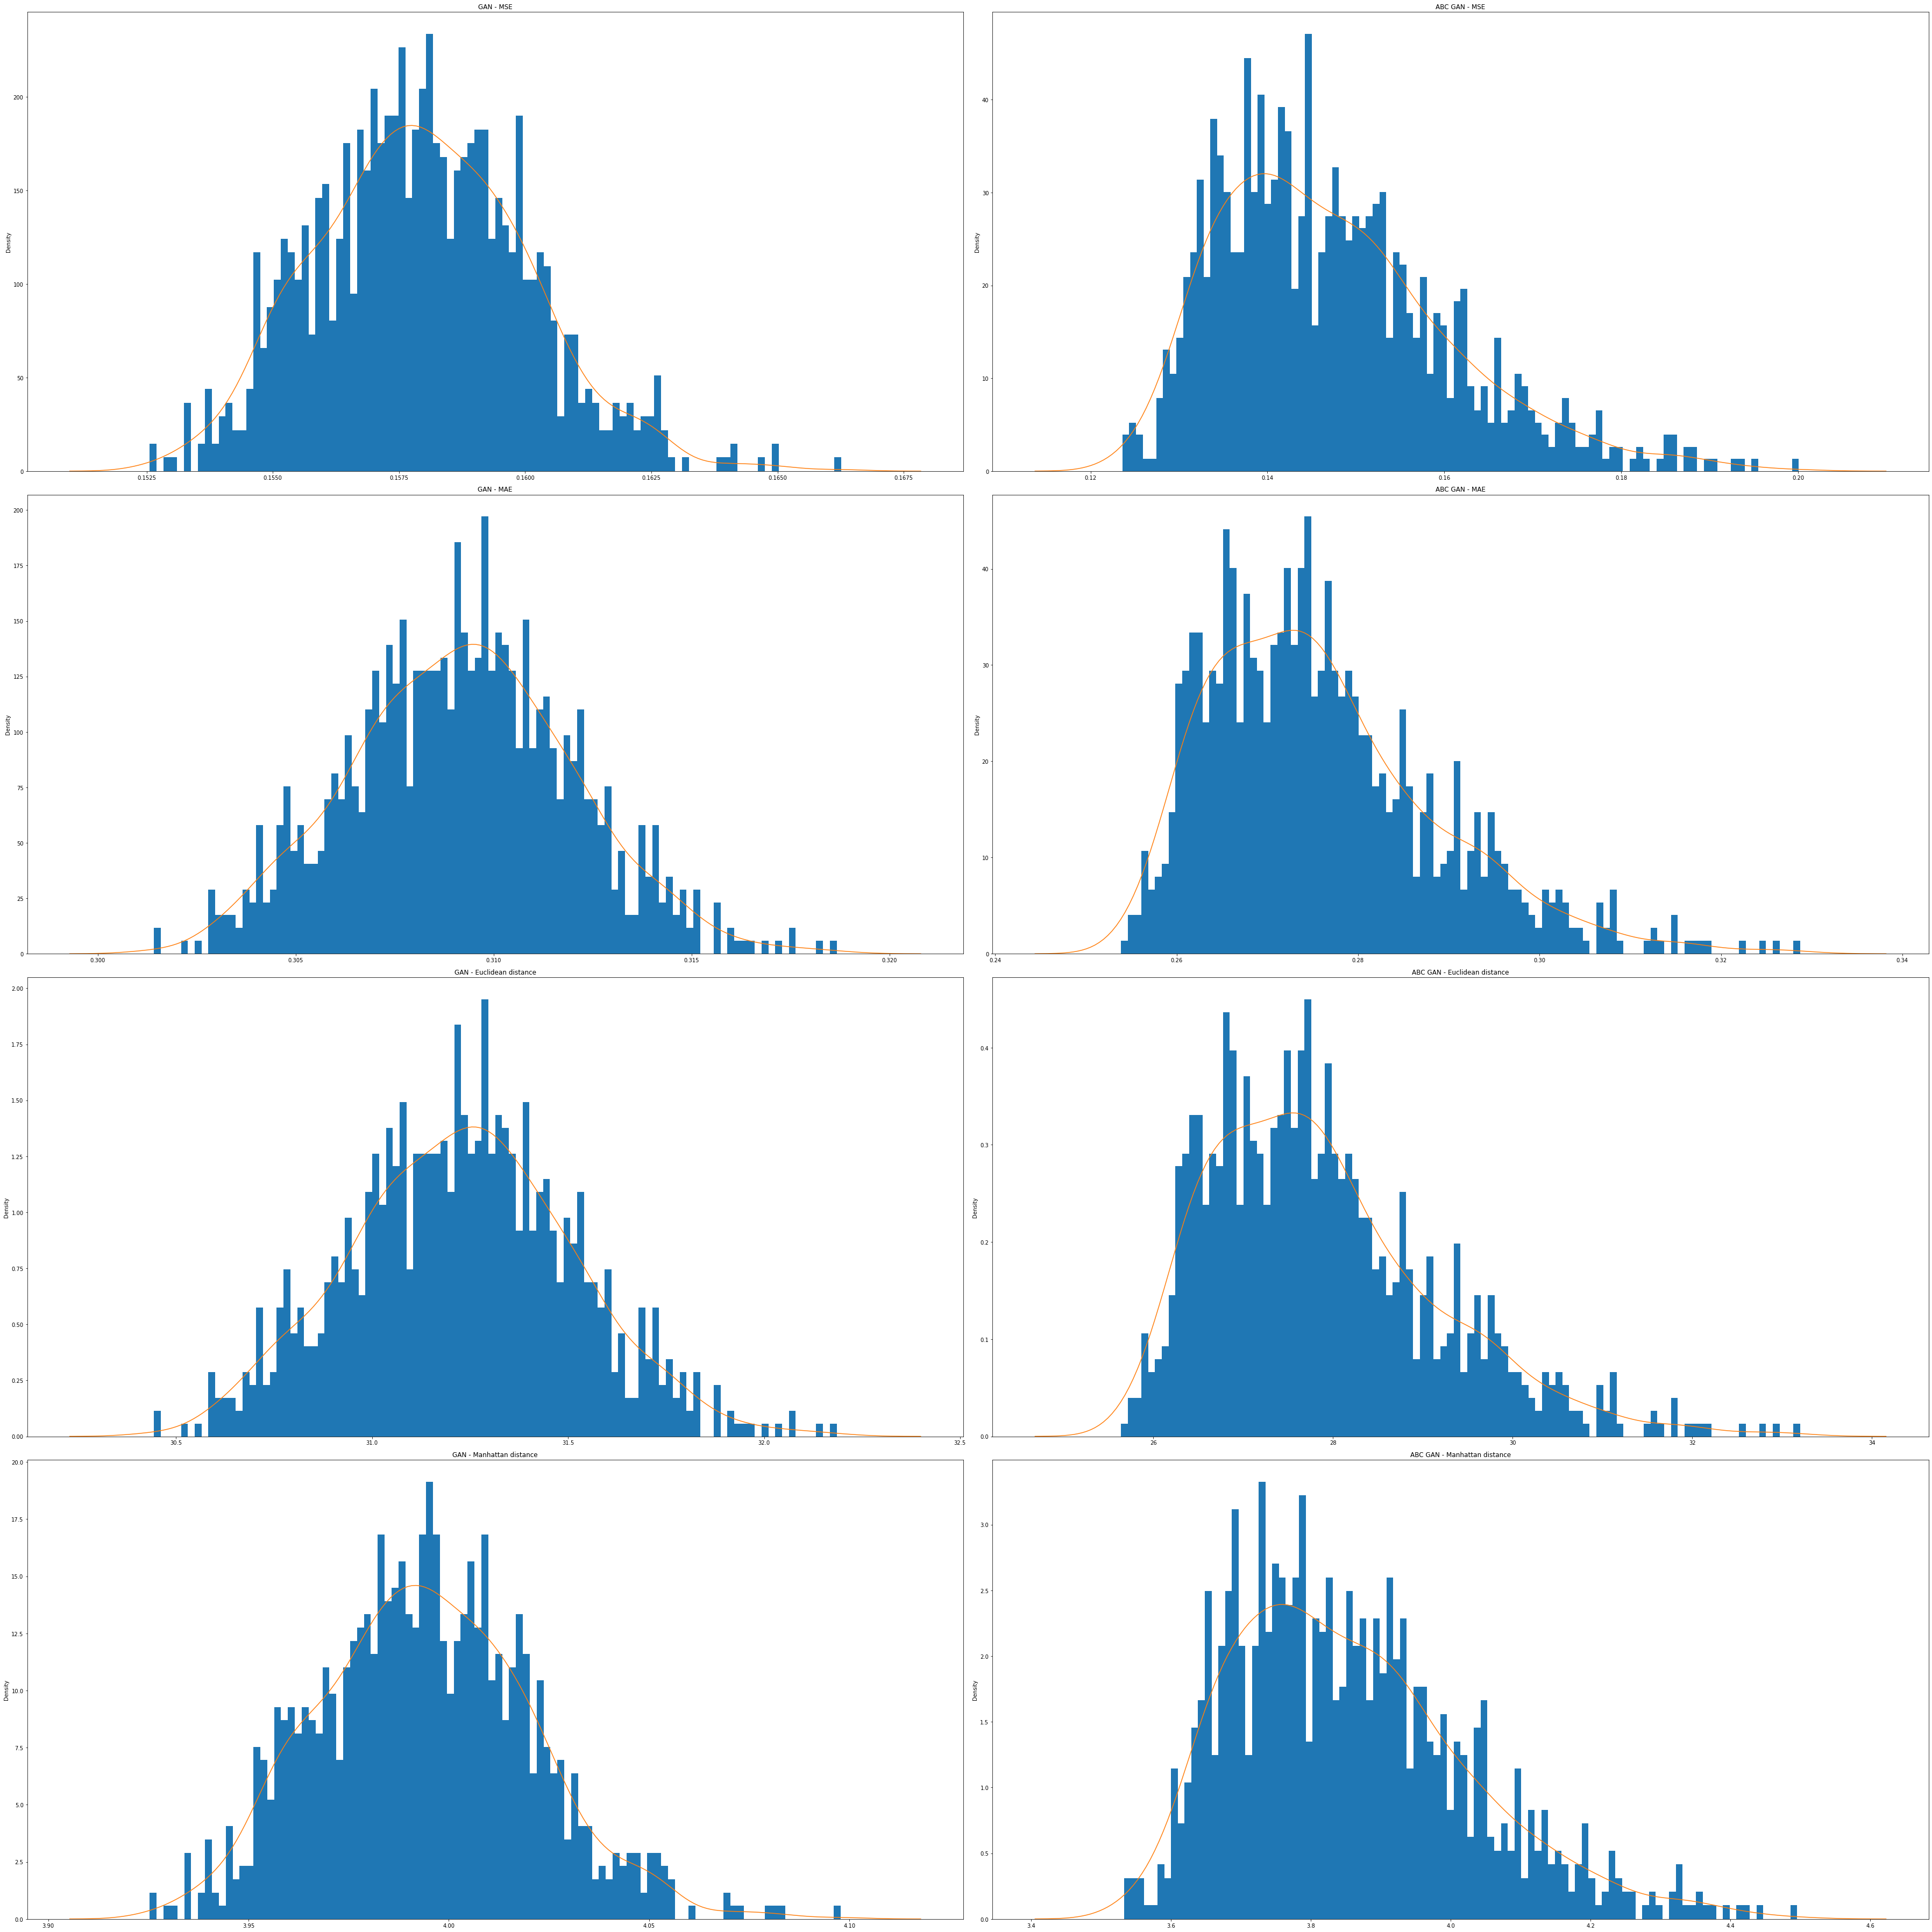

In [41]:
performanceMetrics.modelAnalysis2(GAN3_metrics,ABC_GAN3_metrics)

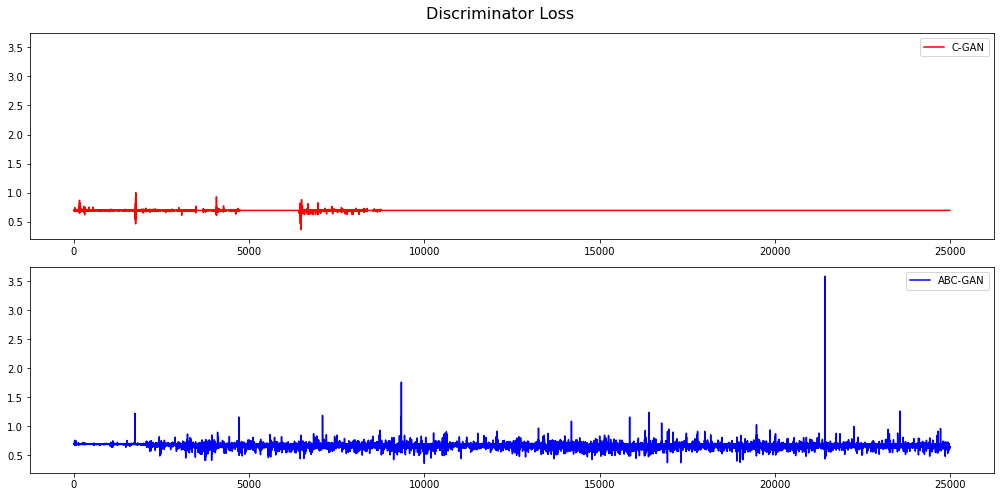

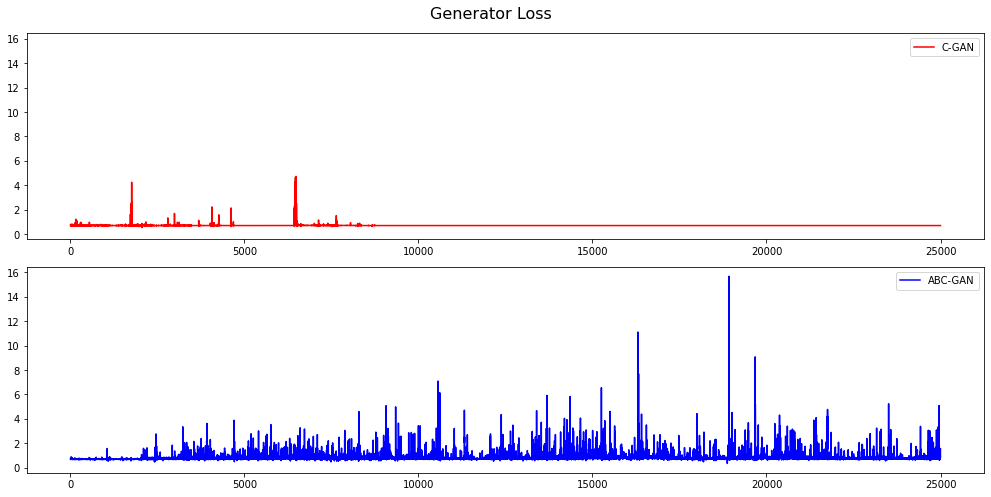

In [42]:
performanceMetrics.plotTrainingLoss2(discLossG3,genLossG3,discLossA3,genLossA3)